# Import Library

In [1]:
import numpy as np
import pandas as pd
import xlwings as xw

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from matplotlib import font_manager, rc
%matplotlib inline
import glob
import os
import json
import geopandas as gpd

matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 기호도 표시
font_name = font_manager.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
rc('font',family = font_name)

import plotly
print(plotly.__version__) # 3.10.0
import cufflinks as cf
import plotly.graph_objs as go
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
from plotly.offline import init_notebook_mode, plot,iplot

init_notebook_mode(connected = True)
cf.go_offline()

import warnings
warnings.filterwarnings(action='ignore') # 경고 메시지를 숨길 때

3.10.0


# Import Dataset

In [2]:
path = 'Rawdata/단독다가구전월세/'
csv_files = glob.glob(os.path.join(path+'*.csv'))

sales = []
for csv_file in csv_files[:]:
     dataset = pd.read_csv(csv_file,
                          index_col=None,
                          skipinitialspace=True,
                          engine = 'python',
                          skiprows=range(0,15),
                          delimiter=',')
                          #usecols=[0,1,4,5,6,7,8,9,10,11])
     
     sales.append(dataset)

apt_rent = pd.concat(sales[0:])
apt_rent.head()

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명
0,강원도 강릉시 교동,1***,12m미만,23.0,전세,201801,31,"3,500",0,2004.0,율곡초교길
1,강원도 강릉시 교동,7**,-,30.0,월세,201801,22,500,35,2017.0,NaN
2,강원도 강릉시 교동,7**,12m미만,30.0,월세,201801,29,500,40,2017.0,화부산로131번길
3,강원도 강릉시 교동,1***,-,30.0,전세,201801,25,"6,000",0,2004.0,NaN
4,강원도 강릉시 교동,9**,12m미만,30.0,전세,201801,28,"5,500",0,2015.0,원대로8번길


In [3]:
apt_rent = apt_rent.iloc[:,:-1]
apt_rent.head()

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도
0,강원도 강릉시 교동,1***,12m미만,23.0,전세,201801,31,"3,500",0,2004.0
1,강원도 강릉시 교동,7**,-,30.0,월세,201801,22,500,35,2017.0
2,강원도 강릉시 교동,7**,12m미만,30.0,월세,201801,29,500,40,2017.0
3,강원도 강릉시 교동,1***,-,30.0,전세,201801,25,"6,000",0,2004.0
4,강원도 강릉시 교동,9**,12m미만,30.0,전세,201801,28,"5,500",0,2015.0


## 변수명을 쉽게 바꿔준다.

In [4]:
apt_rent = apt_rent.rename(index = str, columns={"시군구":"municipality",
                                                   "번지":'zip code',
                                                   #'단지명':'danzi',                                              
                                                   '계약면적(㎡)':'size',
                                                   '계약년월':'contractYM',
                                                   '계약일':'contractD',
                                                    '보증금(만원)':'cost',
                                                     '월세(만원)' : 'month_cost',
                                                #    '층':'floor',
                                                    '건축년도':'builtyear'})
                                                 #   '도로명':'roadname'})
apt_rent.columns

Index(['municipality', 'zip code', '도로조건', 'size', '전월세구분', 'contractYM',
       'contractD', 'cost', 'month_cost', 'builtyear'],
      dtype='object')

In [5]:
apt_rent.info() 
print('-'*70)

# 'cost'에 있는 ,를 제거 그리고 int형으로 변환 #

apt_rent['cost'] = apt_rent['cost'].apply(lambda x:x.replace(',',''))
apt_rent['cost'] = apt_rent['cost'].astype('int64')

#apt_rent['month_cost'] = apt_rent['month_cost'].apply(lambda x:x.replace(',',''))
#apt_rent['month_cost'] = apt_rent['month_cost'].astype('int64')

print("Data type After Changing inappropriate variable types")
apt_rent.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 654571 entries, 0 to 15591
Data columns (total 10 columns):
municipality    654571 non-null object
zip code        654361 non-null object
도로조건            654571 non-null object
size            654571 non-null float64
전월세구분           654571 non-null object
contractYM      654571 non-null int64
contractD       654571 non-null int64
cost            654571 non-null object
month_cost      654571 non-null int64
builtyear       621240 non-null float64
dtypes: float64(2), int64(3), object(5)
memory usage: 54.9+ MB
----------------------------------------------------------------------
Data type After Changing inappropriate variable types
<class 'pandas.core.frame.DataFrame'>
Index: 654571 entries, 0 to 15591
Data columns (total 10 columns):
municipality    654571 non-null object
zip code        654361 non-null object
도로조건            654571 non-null object
size            654571 non-null float64
전월세구분           654571 non-null object
contractYM      6

## 시간정보를 살린다.

In [6]:
apt_rent['date'] = pd.to_datetime(apt_rent['contractYM'],format = '%Y%m').dt.to_period('m').astype('str') + '-' + apt_rent['contractD'].astype('str')
apt_rent['date'] = pd.to_datetime(apt_rent['date'],format = '%Y-%m-%d')
apt_rent['year'] = apt_rent['date'].dt.year
apt_rent['month'] = apt_rent['date'].dt.month
apt_rent['weekday'] = apt_rent['date'].dt.weekday_name
apt_rent['day'] = apt_rent['date'].dt.day

# Deal with Null value and outlier

* 1. Deal with 'builtyear' variable
* 2. Deal with 'roadname' variable
* 3. Deal with 'zip code' variable

Variables that have null values 

* roadname : 24460
* zip code : 23
* builtyear : 1


In [7]:
apt_rent.isnull().sum().to_frame().sort_values(0,ascending=False)

,0
builtyear,33331
zip code,210
municipality,0
도로조건,0
size,0
전월세구분,0
contractYM,0
contractD,0
cost,0
month_cost,0


In [8]:
seo_rent = apt_rent[apt_rent['municipality'].apply(lambda x:x.split(' ')[0]) == '서울특별시']

In [9]:
seo_rent

,municipality,zip code,도로조건,size,전월세구분,contractYM,contractD,cost,month_cost,builtyear,date,year,month,weekday,day
19062,서울특별시 강남구 개포동,1***,8m미만,20.75,월세,201801,18,1000,70,1991.0,2018-01-18,2018,1,Thursday,18
19063,서울특별시 강남구 개포동,1***,12m미만,23.00,월세,201801,17,500,35,1993.0,2018-01-17,2018,1,Wednesday,17
19064,서울특별시 강남구 개포동,1***,12m미만,23.00,월세,201801,17,2000,40,1993.0,2018-01-17,2018,1,Wednesday,17
19065,서울특별시 강남구 개포동,1***,8m미만,27.90,월세,201801,25,2500,40,1996.0,2018-01-25,2018,1,Thursday,25
19066,서울특별시 강남구 개포동,1***,8m미만,30.00,전세,201801,6,9000,0,1992.0,2018-01-06,2018,1,Saturday,6
19067,서울특별시 강남구 개포동,1***,8m미만,30.00,전세,201801,27,8000,0,1990.0,2018-01-27,2018,1,Saturday,27
19068,서울특별시 강남구 개포동,1***,8m미만,30.00,전세,201801,27,8000,0,1990.0,2018-01-27,2018,1,Saturday,27
19069,서울특별시 강남구 개포동,1***,12m미만,33.00,월세,201801,24,5000,35,1996.0,2018-01-24,2018,1,Wednesday,24
19070,서울특별시 강남구 개포동,1***,-,33.00,전세,201801,11,10000,0,1990.0,2018-01-11,2018,1,Thursday,11
19071,서울특별시 강남구 개포동,1***,12m미만,33.00,전세,201801,24,13000,0,1996.0,2018-01-24,2018,1,Wednesday,24


# 중요 변수들 EDA

## 월세의 크기에 관한 분포가 다름을 확인할 수 있다.



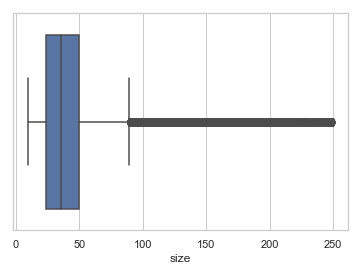

In [10]:
sns.set(style='whitegrid')
sns.boxplot(x=seo_rent['size'])

## 보증금의 변동폭이 큰 것을 확인할 수 있다.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B0135186D8>],
      dtype=object)

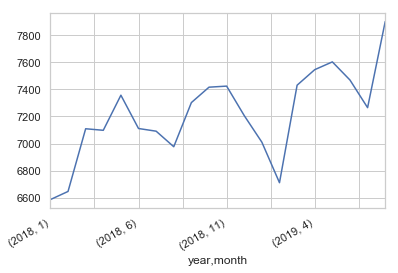

In [11]:
seo_rent.groupby(['year','month'])['cost'].mean().plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B013593B00>],
      dtype=object)

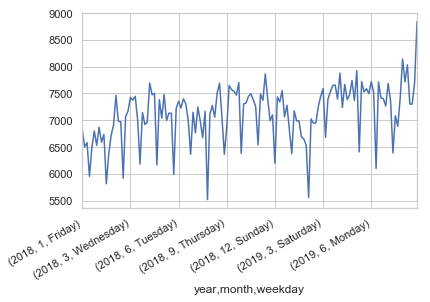

In [12]:
seo_rent.groupby(['year','month','weekday'])['cost'].mean().plot(subplots=True)

## 월세의 변동폭도 큰 것을 확인할 수 있다.

- 월세와 보증금은 서로 역방향임을 발견할 수 있다.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B0135D9CC0>],
      dtype=object)

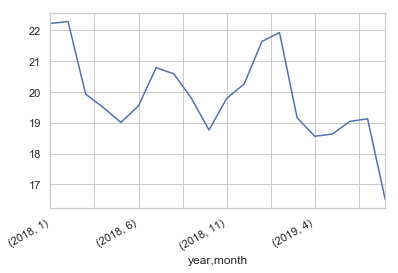

In [13]:
seo_rent.groupby(['year','month'])['month_cost'].mean().plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B013618DA0>],
      dtype=object)

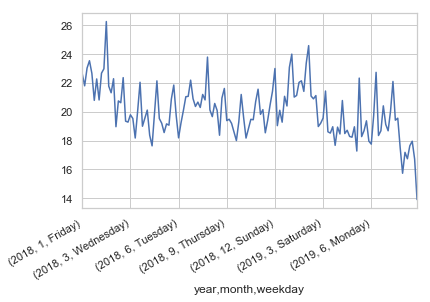

In [14]:
seo_rent.groupby(['year','month','weekday'])['month_cost'].mean().plot(subplots=True)

In [15]:
seo_rent['dong'] = seo_rent['municipality'].apply(lambda x:x.split( )[2])
seo_rent.isnull().sum()

municipality       0
zip code          30
도로조건               0
size               0
전월세구분              0
contractYM         0
contractD          0
cost               0
month_cost         0
builtyear       9918
date               0
year               0
month              0
weekday            0
day                0
dong               0
dtype: int64

In [16]:
seo_rent['gu'] = seo_rent['municipality'].apply(lambda x:x.split( )[1])

In [17]:
tt = pd.DataFrame(seo_rent.groupby(['gu'])['month_cost'].mean())
tt['HDONG_NM'] = tt.index
tt

,month_cost,HDONG_NM
gu,,
강남구,31.386110,강남구
강동구,17.393150,강동구
강북구,17.550080,강북구
강서구,15.617039,강서구
관악구,19.933995,관악구
광진구,20.718394,광진구
구로구,16.707830,구로구
금천구,18.258335,금천구
노원구,17.612827,노원구


In [18]:
shape_visual = gpd.read_file('Rawdata/지역/scco_slg.shp',
                             encoding = 'euckr')

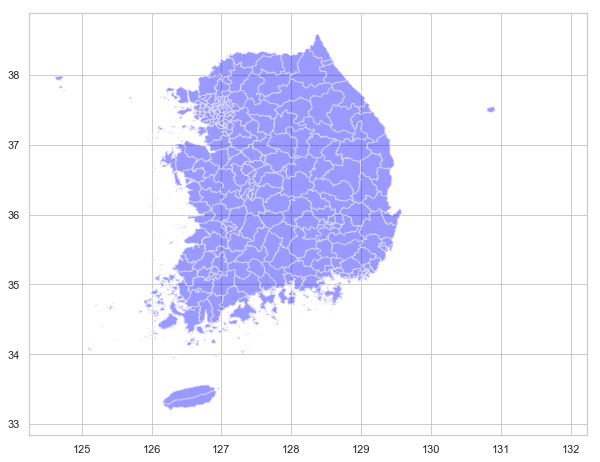

In [19]:
fig,ax = plt.subplots(figsize = (10,10))
shape_visual.plot(ax = ax, alpha=0.4,color = 'blue')